# What Traits make the Perfect Wide Receiver, and how can we use these to Predict Yardage?

CMSC320 - Final Tutorial <br>
Section 0201 <br>
Sumanth Patil, Jason Trehan

## Getting Started (imports, liibrary def., etc)

In [245]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import pandas as pd
import datetime
import re
import difflib as dl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import warnings

# Introduction and Motivation

The NFL over the years has become an increasingly offensive league. Offense traditionally has an advantage over defense due to the proactive versus reactive nature of either side respectively. However, during the 70s-90s, passing plays were largely a secondary option used to convert on 3rd and long, or used at the end of close games to move the ball down field faster. It wasn't until the 2000s, the arrival of legendary Quarterbacks such as Peyton Manning, Tom Brady, Drew Brees, etc. that the passing game really started to mature league wide. However, Quarterbacks were only as successful as their Wide Receivers. Without generational receiving talents such as Randy Moss, Terrell Owens, Marving Harrison, etc. passing games would still be anemic. 

With this in context, the 2021 Offensive season was extremely skewed. We saw 23 Wide Receivers with over 1000 Yards, and even saw Cooper Kupp come close to breaking the single season receiving record, the first receiver with 1900+ yards since Calvin Johnson back in 2012. Additionally, 2020 only saw 16 WRs with over 1000 yards. This is largely due to the many defensive injuries, especially in the backfield this year. In fact, there were 65 major injuries to rostered Defensive Backs including Safeties, and Cornerbacks. These are the primary assigned defenders who cover WRs. On the other hand, there were only 33 major injuries to WRs, many of whom are lower tier receivers. 

#### **SO the main purpose and motivation of this analysis is to determine, which physical, and ability based features can be used to predict a more realistic receiving year for the top WRs. Essentially, which attributes make the perfect Wide Receiver, and how can we use them in interaction with one another to predict a more realistic receiving year across the league.** 

Citations:
https://www.espn.com/nfl/injuries<br>
https://www.sharpfootballanalysis.com/analysis/nfl-injury-report-ir-tracker-2021/<br>
https://www.statmuse.com/nfl/ask/how-many-receivers-last-year-have-1000-yards-receiving<br>
https://www.statmuse.com/nfl/ask/how-many-receivers-have-1000-yards-receiving-2020

# Curating Data

Here we use stathead.com (https://stathead.com/football/nfl-combine-results.cgi) and their unique databases of NFL data to pull NFL Combine results/specs from years 2010-2021. The NFL combine is an invitation based showcase of college students entering the NFL draft. Here they take official physicals, skill scores, etc. We will be using the 40 yard dash, standing vertical jump, weight, and height extensively to determine the raw athletic ability and its relation to receiving performances later on. 

Additionally, the 2021-2022 NFL Receiving Leaders data has been curated via CSV export from NFL's Next Gen Stats website: https://nextgenstats.nfl.com/stats/receiving#yards.

In [246]:
comb10to15 = pd.read_csv('combine_2010-2015.csv')
comb15to21 = pd.read_csv('combine_2015-2021.csv')
recyds2021 = pd.read_csv('2021recleaders.csv')

### Tidying and Modifying Data

Here we will combine the two Combine data sets as well as drop the lowest 97 receiving performers. We will be looking at the top 30, as this will show us the qualities attributing the top wide receivers in the NFL. 

In [247]:
recyds2021 = recyds2021.iloc[:-97]
full_combine = pd.concat([comb15to21,comb10to15])

full_combine = full_combine.reset_index(drop=True).drop(columns={"Rk"})
for i in range(0,len(full_combine)):
    slashindex = str((full_combine.at[i,'Player'])).index('\\')
    name = full_combine.at[i,"Player"]
    full_combine.at[i,"Player"] = (name)[0:slashindex]

### Combining Dataframes

Here we add physicals from the Combine data to the receiving performance dataframe to localize all relevant data. 

In [248]:
weights = []
heights = []
yd40dashes = []
verticals = []
playersfound = []
for i in range(0,30):
    player = recyds2021.at[i,"Player"]
    found = False
    for j in range(0,len(full_combine)):
        if(found == False and full_combine.at[j,"Player"] == player):
            found = True
            weights.append(full_combine.at[j,"Wt"])
            heights.append(full_combine.at[j,"Height"])
            yd40dashes.append(full_combine.at[j,"40YD"])
            verticals.append(full_combine.at[j,"Vertical"])
            playersfound.append(player)

for index, row in recyds2021.iterrows():
    if not row['Player'] in playersfound:
        recyds2021.drop(index, inplace=True)
            
recyds2021['weight'] = weights
recyds2021['height'] = heights
recyds2021['40yddash'] = yd40dashes
recyds2021['vertical'] = verticals

recyds2021

,Player,team,position,cushion,seperation,tay,tay%,rec,tar,catch%,yds,td,yac/r,xyac/r,+-,weight,height,40yddash,vertical
0,Cooper Kupp,NFC,WR,6.5,3.6,8.4,31.32,145,191,75.92,1947,16,6.2,4.8,1.3,204,6-2,4.62,31.0
1,Justin Jefferson,NFC,WR,5.7,3.0,12.3,45.27,108,167,64.67,1616,10,4.7,4.0,0.8,202,6-1,4.43,37.5
2,Davante Adams,NFC,WR,5.3,2.9,9.1,35.27,123,169,72.78,1553,11,5.4,4.8,0.6,212,6-1,4.56,39.5
3,Ja'Marr Chase,AFC,WR,5.0,2.3,12.7,37.38,81,128,63.28,1455,13,8.3,3.9,4.4,201,6-0,4.34,41.0
4,Deebo Samuel,NFC,WR,6.7,3.3,8.7,26.61,77,121,63.64,1397,6,10.4,5.2,5.2,214,5-11,4.48,39.0
7,Stefon Diggs,AFC,WR,5.1,2.7,11.6,35.43,103,164,62.80,1225,10,3.3,3.0,0.2,195,6-0,4.46,35.0
8,Tyler Lockett,SEA,WR,7.0,3.2,14.9,35.58,73,107,68.22,1175,8,4.2,3.9,0.2,182,5-10,4.40,35.5
9,Diontae Johnson,AFC,WR,4.6,3.2,8.4,32.44,107,169,63.31,1161,8,5.1,5.1,0.0,183,5-10,4.53,33.5
10,D.J. Moore,CAR,WR,5.6,2.7,10.6,40.21,93,163,57.06,1157,4,5.0,4.6,0.4,210,6-0,4.42,39.5
11,Mike Williams,LAC,WR,5.3,2.5,11.6,29.63,76,129,58.91,1146,9,5.9,4.4,1.4,218,6-4,NaN,32.5


### Filling in Missing Values

There are a few missing values for players who may have not attended the combine or failed to test in some of the physicals. We will use external resources to fill in these missing values:<br>
Mike Williams:https://nflcombineresults.com/playerpage.php?i=27001 <br>
Keenan Allen:https://www.nfl.com/prospects/keenan-allen/3200414c-4c53-2966-dfa9-55ae464e7b3d <br>
Tee Higgins: https://13wham.com/buffalo-plus/bills-latest-news/source-higgins-pro-day-led-to-diggs-deal#:~:text=According%20to%20Pro%20Football%20Network,second%20percentile%20among%20wide%20receivers.<br>
Marquise Brown: https://heavy.com/sports/2020/01/marquise-brown-speed-40-yard-dash-time-ravens/
http://www.espn.com/college-sports/football/recruiting/player/combine/_/id/174009/marquise-brown <br>

In [249]:
recyds2021.at[11,'40yddash'] = 4.54
recyds2021.at[12,'vertical'] = 36.0
recyds2021.at[16,'40yddash'] = 4.54
recyds2021.at[16,'vertical'] = 31.0
recyds2021.at[25,'40yddash'] = 4.33
recyds2021.at[25,'vertical'] = 33.0

recyds2021

,Player,team,position,cushion,seperation,tay,tay%,rec,tar,catch%,yds,td,yac/r,xyac/r,+-,weight,height,40yddash,vertical
0,Cooper Kupp,NFC,WR,6.5,3.6,8.4,31.32,145,191,75.92,1947,16,6.2,4.8,1.3,204,6-2,4.62,31.0
1,Justin Jefferson,NFC,WR,5.7,3.0,12.3,45.27,108,167,64.67,1616,10,4.7,4.0,0.8,202,6-1,4.43,37.5
2,Davante Adams,NFC,WR,5.3,2.9,9.1,35.27,123,169,72.78,1553,11,5.4,4.8,0.6,212,6-1,4.56,39.5
3,Ja'Marr Chase,AFC,WR,5.0,2.3,12.7,37.38,81,128,63.28,1455,13,8.3,3.9,4.4,201,6-0,4.34,41.0
4,Deebo Samuel,NFC,WR,6.7,3.3,8.7,26.61,77,121,63.64,1397,6,10.4,5.2,5.2,214,5-11,4.48,39.0
7,Stefon Diggs,AFC,WR,5.1,2.7,11.6,35.43,103,164,62.80,1225,10,3.3,3.0,0.2,195,6-0,4.46,35.0
8,Tyler Lockett,SEA,WR,7.0,3.2,14.9,35.58,73,107,68.22,1175,8,4.2,3.9,0.2,182,5-10,4.40,35.5
9,Diontae Johnson,AFC,WR,4.6,3.2,8.4,32.44,107,169,63.31,1161,8,5.1,5.1,0.0,183,5-10,4.53,33.5
10,D.J. Moore,CAR,WR,5.6,2.7,10.6,40.21,93,163,57.06,1157,4,5.0,4.6,0.4,210,6-0,4.42,39.5
11,Mike Williams,LAC,WR,5.3,2.5,11.6,29.63,76,129,58.91,1146,9,5.9,4.4,1.4,218,6-4,4.54,32.5


# Exploratory Data Analysis

We will be calculating raw athletic score, and plotting other measureables against receiving yards to determine which factors have the highest correaltion towards receiving ability and performance.

### Calculating Raw Athletic Score (RAS)

Raw Athletic Score will be a score dependent on the 40yd Dash and Vertical metrics, the most important physical specs for a wide receiver. The score will be calculated as such: RAS = ((5.00-(40yd Dash))/ 1) + (vertical/42).

We are deriving peak percentile by taking the difference from the dash to 5.00 (the worst time) and dividing by 1. This will give us an inverted score where fastest runners (smaller times) have a higher score. With verticals, since higher is better, this can be divided directly. 

In [250]:
recyds2021["ras"] = ((5.0-recyds2021["40yddash"])/1) + (recyds2021["vertical"]/42)
recyds2021.head()

,Player,team,position,cushion,seperation,tay,tay%,rec,tar,catch%,yds,td,yac/r,xyac/r,+-,weight,height,40yddash,vertical,ras
0,Cooper Kupp,NFC,WR,6.5,3.6,8.4,31.32,145,191,75.92,1947,16,6.2,4.8,1.3,204,6-2,4.62,31.0,1.118095
1,Justin Jefferson,NFC,WR,5.7,3.0,12.3,45.27,108,167,64.67,1616,10,4.7,4.0,0.8,202,6-1,4.43,37.5,1.462857
2,Davante Adams,NFC,WR,5.3,2.9,9.1,35.27,123,169,72.78,1553,11,5.4,4.8,0.6,212,6-1,4.56,39.5,1.380476
3,Ja'Marr Chase,AFC,WR,5.0,2.3,12.7,37.38,81,128,63.28,1455,13,8.3,3.9,4.4,201,6-0,4.34,41.0,1.636190
4,Deebo Samuel,NFC,WR,6.7,3.3,8.7,26.61,77,121,63.64,1397,6,10.4,5.2,5.2,214,5-11,4.48,39.0,1.448571


### Calculating Yards per Rec

Since each WR has to deal with the strengths and short comings of their Quarterback we will use a standardized metric for our results. Yards/Rec. This takes away target bias, quarterback deficiency, etc. 

In [251]:
recyds2021["yds/rec"] = recyds2021["yds"]/recyds2021["rec"]
recyds2021.head()

,Player,team,position,cushion,seperation,tay,tay%,rec,tar,catch%,...,td,yac/r,xyac/r,+-,weight,height,40yddash,vertical,ras,yds/rec
0,Cooper Kupp,NFC,WR,6.5,3.6,8.4,31.32,145,191,75.92,...,16,6.2,4.8,1.3,204,6-2,4.62,31.0,1.118095,13.427586
1,Justin Jefferson,NFC,WR,5.7,3.0,12.3,45.27,108,167,64.67,...,10,4.7,4.0,0.8,202,6-1,4.43,37.5,1.462857,14.962963
2,Davante Adams,NFC,WR,5.3,2.9,9.1,35.27,123,169,72.78,...,11,5.4,4.8,0.6,212,6-1,4.56,39.5,1.380476,12.626016
3,Ja'Marr Chase,AFC,WR,5.0,2.3,12.7,37.38,81,128,63.28,...,13,8.3,3.9,4.4,201,6-0,4.34,41.0,1.636190,17.962963
4,Deebo Samuel,NFC,WR,6.7,3.3,8.7,26.61,77,121,63.64,...,6,10.4,5.2,5.2,214,5-11,4.48,39.0,1.448571,18.142857


### Calculating Lost Cushion

Cushion is defined as the space afforded to a specific receiver by the defender assigned to him in coverage. Seperation is the space remaining between the assigned defender and receiver at the point of pass arrival. So a receiver's lost cushion is simply: lost cushion = initial cushion - separation. This shows how much of the initial cushion the receiver lost and can be an indicator of agility, route running, and release. 

In [252]:
recyds2021["lost cushion"] = recyds2021["cushion"] - recyds2021["seperation"]
recyds2021

,Player,team,position,cushion,seperation,tay,tay%,rec,tar,catch%,...,yac/r,xyac/r,+-,weight,height,40yddash,vertical,ras,yds/rec,lost cushion
0,Cooper Kupp,NFC,WR,6.5,3.6,8.4,31.32,145,191,75.92,...,6.2,4.8,1.3,204,6-2,4.62,31.0,1.118095,13.427586,2.9
1,Justin Jefferson,NFC,WR,5.7,3.0,12.3,45.27,108,167,64.67,...,4.7,4.0,0.8,202,6-1,4.43,37.5,1.462857,14.962963,2.7
2,Davante Adams,NFC,WR,5.3,2.9,9.1,35.27,123,169,72.78,...,5.4,4.8,0.6,212,6-1,4.56,39.5,1.380476,12.626016,2.4
3,Ja'Marr Chase,AFC,WR,5.0,2.3,12.7,37.38,81,128,63.28,...,8.3,3.9,4.4,201,6-0,4.34,41.0,1.636190,17.962963,2.7
4,Deebo Samuel,NFC,WR,6.7,3.3,8.7,26.61,77,121,63.64,...,10.4,5.2,5.2,214,5-11,4.48,39.0,1.448571,18.142857,3.4
7,Stefon Diggs,AFC,WR,5.1,2.7,11.6,35.43,103,164,62.80,...,3.3,3.0,0.2,195,6-0,4.46,35.0,1.373333,11.893204,2.4
8,Tyler Lockett,SEA,WR,7.0,3.2,14.9,35.58,73,107,68.22,...,4.2,3.9,0.2,182,5-10,4.40,35.5,1.445238,16.095890,3.8
9,Diontae Johnson,AFC,WR,4.6,3.2,8.4,32.44,107,169,63.31,...,5.1,5.1,0.0,183,5-10,4.53,33.5,1.267619,10.850467,1.4
10,D.J. Moore,CAR,WR,5.6,2.7,10.6,40.21,93,163,57.06,...,5.0,4.6,0.4,210,6-0,4.42,39.5,1.520476,12.440860,2.9
11,Mike Williams,LAC,WR,5.3,2.5,11.6,29.63,76,129,58.91,...,5.9,4.4,1.4,218,6-4,4.54,32.5,1.233810,15.078947,2.8


### Yards/Rec vs RAS

Here we will develop a relation (or non-relation) between Raw Athletic ability and the yards/rec for each WR. 

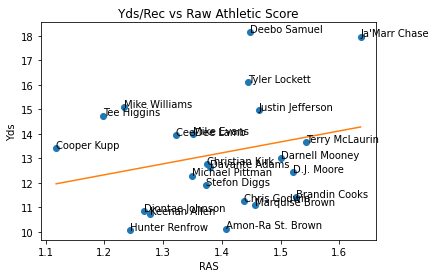

In [253]:
xaxis = recyds2021['ras'].values
yaxis = recyds2021['yds/rec'].values
line = np.poly1d(np.polyfit(x=xaxis,y=yaxis,deg=1))
xrange = np.linspace(xaxis.min(), xaxis.max(), 100)
yrange = line(xrange)

for l, label in enumerate(recyds2021["Player"].values):
        plt.annotate(label, (xaxis[l], yaxis[l]))

plt.plot(xaxis, yaxis,'o', xrange, yrange)
plt.title("Yds/Rec vs Raw Athletic Score")
plt.xlabel("RAS")
plt.ylabel("Yds")
plt.show()

As we can see by the trend line there seems to be a positive correlation between Raw Athletic Ability and receiving performance. This is best attributed by Ja'Marr Chase who had 1400+ receiving yards as a rookie. He also split reps and targets with Tyler Boyd and Tee Higgins, and yet posted extremely high reception stats due to his athletic prowess. The only true exception to this conjecture is Cooper Kupp who led the league in receiving whilst having the worst RAS. 

### Targets vs Lost Cushion

Here we will develop a relation (or non-relation) between Cushion Loss and total targets for each WR.

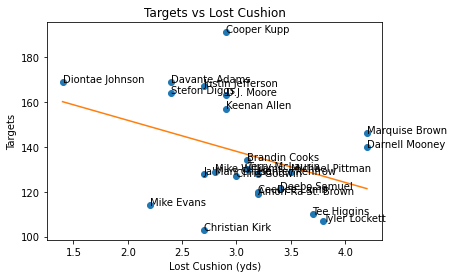

In [254]:
xaxis = recyds2021['lost cushion'].values
yaxis = recyds2021['tar'].values
line = np.poly1d(np.polyfit(x=xaxis,y=yaxis,deg=1))
xrange = np.linspace(xaxis.min(), xaxis.max(), 100)
yrange = line(xrange)

for l, label in enumerate(recyds2021["Player"].values):
        plt.annotate(label, (xaxis[l], yaxis[l]))

plt.plot(xaxis, yaxis,'o', xrange, yrange)
plt.title("Targets vs Lost Cushion")
plt.xlabel("Lost Cushion (yds)")
plt.ylabel("Targets")
plt.show()

The trend line shows there is high correlation between getting targets and the lost cushion. The higher a cusion that is lost (smaller separation) the less likely it is that the QB will target. This trend makes sense intuitively, the quarterback must read who is most open and make a decision on who to past to. The targets with higher cushions and separation (less cushion lost) will naturally see a higher number of targets. So we see that ability to create separation or maintain cushion is non-trivial. 

### Separation vs Catch%

Here we will develop a relation (or non-relation) between Separation and catcg% for each WR.

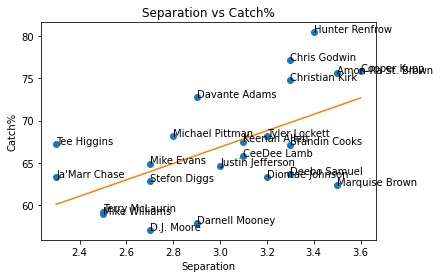

In [205]:
xaxis = recyds2021['seperation'].values
yaxis = recyds2021['catch%'].values
line = np.poly1d(np.polyfit(x=xaxis,y=yaxis,deg=1))
xrange = np.linspace(xaxis.min(), xaxis.max(), 100)
yrange = line(xrange)

for l, label in enumerate(recyds2021["Player"].values):
        plt.annotate(label, (xaxis[l], yaxis[l]))

plt.plot(xaxis, yaxis,'o', xrange, yrange)
plt.title("Separation vs Catch%")
plt.xlabel("Separation")
plt.ylabel("Catch%")
plt.show()

So there is very strong positive correlation between seperation and catch%. This makes sense, as the more space between a reciever and a defender, the higher chance of securing the ball. 

# Machine Learning (OLS Multiple Regression)

### Why use Multiple Regression?

We are going to use an OLS Multiple Regression, because we want to predict yards (dependent variable) using the other variables. Linear regression is used when a single response variable is being predicted using a single independent variable. However, in our case, we are trying to predict yardage as an interaction between Separation, Cushion, Lost Cushion, RAS, and targets. Hence, we will develop a formula to determine the predicted yardage and use OLS Multiple Regression to determine how well this interaction formula correlates to the predicted yardage. We can then graph the distribution to see how well we did.

### What is our Null Hypothesis?

Based on our Exploratory Data Analysis, we are going to surmise, before doing any correlation statistics, that the separation, cushion, lost cushion, targets, and ras specs are non-trivial influencers: they have a strong relation to yardage output. 

### Formula for Yards Prediction

Firstly, NFL yardage patterns are very proportional to targeting, athletic ability, and route running. The better a receiver is at all of these, the more linear their receiving patterns over the years are. Hence, our formula will use a linear setup, extrpolated over total targets. 

By gathering the total cushion metrics (positive and negative) and multiplying by Raw Athletic Score we get a good estimate of how many yards are being averaged per target by each receiver: this is the yards gained for everytime a quarterback throws the ball a receivers way regardless of the catch being made. By extrapolating this yardage over the total number of targets, we can get a good estimate of total Yards.

Yards Prediction = (seperation + cushion - lost cushion) * RAS * (targets)

In [242]:
predictions2021 = pd.DataFrame()

predictions2021["Player"] = recyds2021["Player"].values
predictions2021["seperation"] = recyds2021["seperation"].values
predictions2021["cushion"] = recyds2021["cushion"].values
predictions2021["lost cushion"] = recyds2021["lost cushion"].values
predictions2021["tar"] = recyds2021["tar"].values
predictions2021["rec"] = recyds2021["rec"].values
predictions2021["ras"] = recyds2021["ras"].values

predictions2021["ydsPred"] = (predictions2021["seperation"] + predictions2021["cushion"] - predictions2021["lost cushion"]) * predictions2021["ras"] * (predictions2021["tar"])

Now that we have developed and curated predictions via the formula, let us test the correlation strength. 

In [243]:
recyds2021["predyds"] = predictions2021["ydsPred"]
X = recyds2021.drop(columns=['predyds'], axis=1)
Y = recyds2021['predyds']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)
X_train['predyds'] = Y_train
mod = ols(formula="predyds ~ (seperation + cushion - (lost cushion)) * ras * tar", data=X_train).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                predyds   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     4.202
Date:                Wed, 04 May 2022   Prob (F-statistic):              0.208
Time:                        18:00:53   Log-Likelihood:                -70.819
No. Observations:                  14   AIC:                             165.6
Df Residuals:                       2   BIC:                             173.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.021e+04   6.18e+04      0.327      0.775   -2.46e+05    2.86e+05
seperation          8184.8464   3.97e+04      0.206      0.856   -1.63e+05    1.79e+05
cushion            -6884.3364    1.8e+04     -0.383      0.738   -8.42e+04    7.04e+04
ras                -2.836e+04   4.64e+04     -0.611      0.603   -2.28e+05    1.71e+05
seperation:ras     -2734.6804   3.38e+04     -0.081      0.943   -1.48e+05    1.42e+05
cushion:ras         5898.0656   1.36e+04      0.435      0.706   -5.24e+04    6.42e+04
tar                 -229.4270    491.065     -0.467      0.686   -2342.307    1883.453
seperation:tar       -73.8657    271.918     -0.272      0.811   -1243.835    1096.104
cushion:tar           75.0805    112.952      0.665      0.575    -410.912     561.073
ras:tar              279.6411    380.358      0.735      0.539   -1356.909    1916.191
seperation:ras:tar    29.6716    233.910      0.127      0.911    -976.763    1036.107
cushion:ras:tar      -62.0822     85.163     -0.729      0.542    -428.508     304.344
==============================================================================
Omnibus:                        3.071   Durbin-Watson:                   1.343
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                0.927
Skew:                           0.460   Prob(JB):                        0.629
Kurtosis:                       3.863   Cond. No.                     4.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R^2 value is:

**0.959**

As we see by the R-Squared metric, we find a very high correlation strength between the given formula and predicted yards. These 5 factors are extremely important and influential in how well a WR does. Therefore, we accept the initial null hypothesis that these 5 factors are non-trivial influencers. 

Knowing that the prediction formula has a strong correlation strength (good fit), let us now graph the predictions against the actual values. 

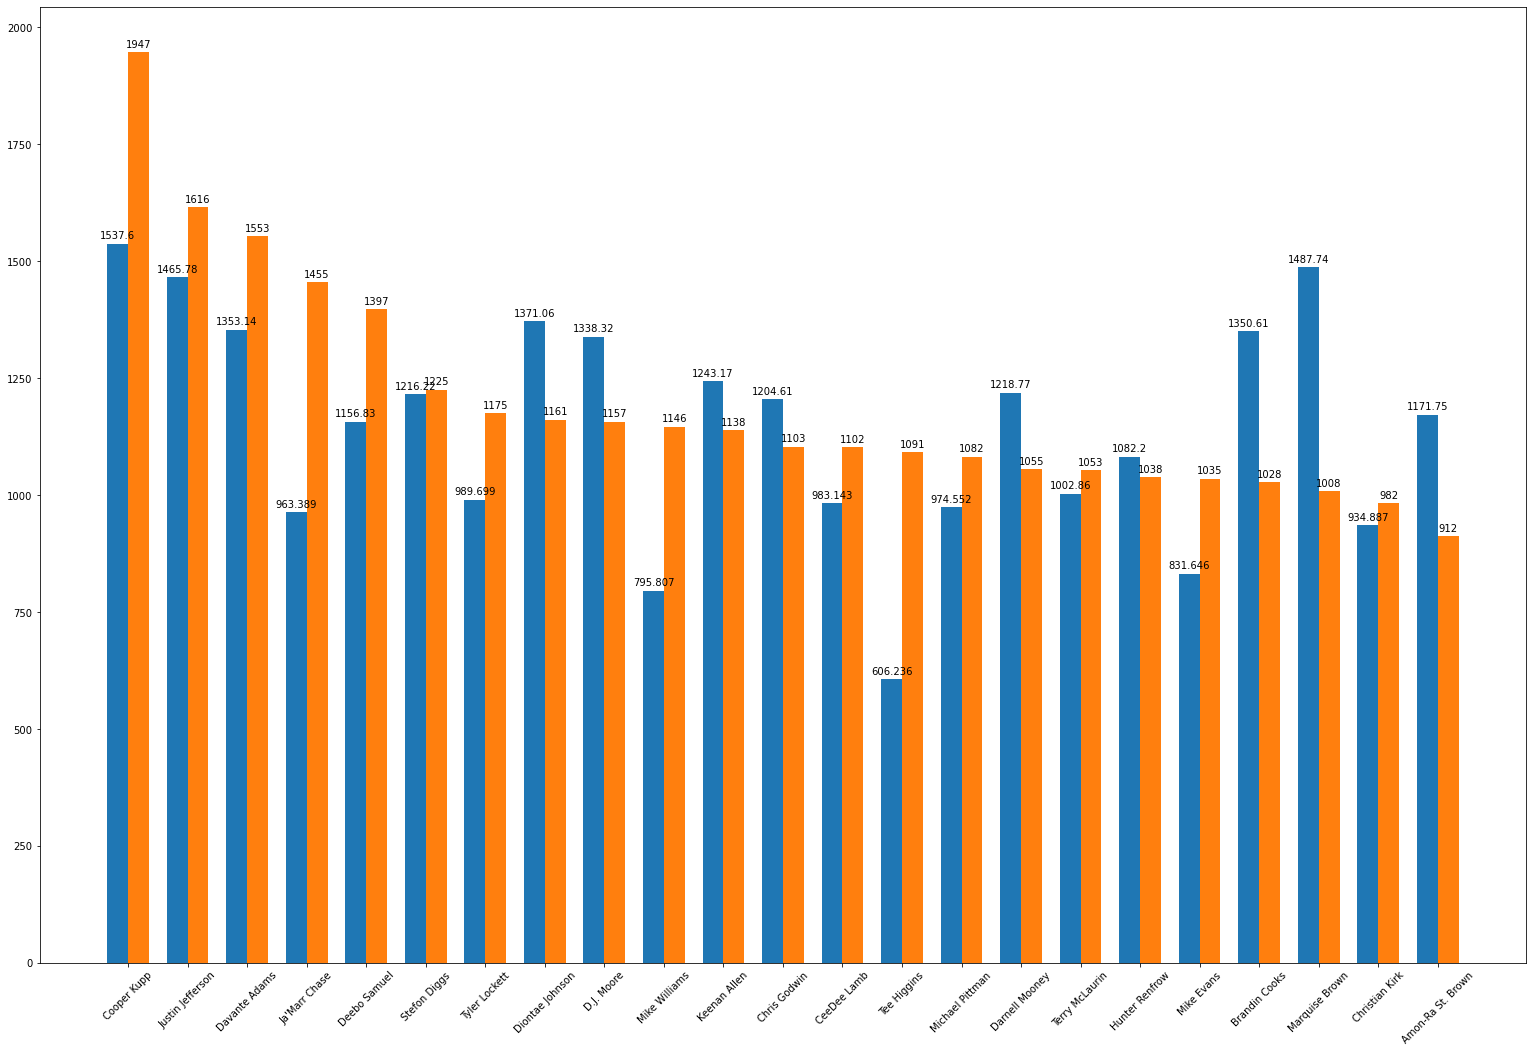

In [244]:
from matplotlib.pyplot import figure
labels = recyds2021["Player"].values
preds = predictions2021["ydsPred"].values
actual = recyds2021["yds"].values

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, preds, width, label='Predictions')
rects2 = ax.bar(x + width/2, actual, width, label='Actual')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.set_xticks(x, labels)

fig.tight_layout()
fig.set_size_inches(25.5, 15.5)
fig.savefig('test2png.png', dpi=100)

plt.xticks(rotation = 45)
plt.show()

# Final Observations and Pipeline Walkthrough

### Data Collection, Curation, Modification, Motivation, etc. 
Consider the high-level task: Predict receiving performances for top WRs in a year less offensively focused than 2021. 

As aforementioned, the motivating feature of this analysis was to determine more normalized receiving numbers for top wrs in the NFL. This past NFL season saw a huge up tick in offensive output due to the injuries of major defensive players across the league. Operating off these parameters, we need to use other metrics to get a more realistic projection of receiving yards. 

We used the 2021 NFL Receiving data via Next Gen Stats, and NFL Combine data from 2010-2021. We also filled in missing physicals values via external sources. 

### Exploratory Data Analysis

After an EDA, we determined there is a positive correlation between Yards/Reception and Raw Athletic Score(RAS). We also found a negative correlation between Lost Cushion and Targets. And lastly, a positive correlation between Separation and Catch%. Essentially, we discovered that the total distance between pass catcher and defender, raw atheltic score, and targets are good indicators of overall receiving performance.

Null Hypothesis: the separation, cushion, lost cushion, targets, and ras specs are non-trivial influencers: they have a strong relation to yardage output.

### Hypothesis Testing via OLS Multiple Regression

Here we find that there is a high correlation between these factors and total receiving output/performance.

R-Squared = .959

### Insights

Lost Cushion is a negative influencer for receiving performance<br>
Cushion is a positive influencer for receiving performance<br>
Separation is a positive influencer for receiving performance<br>
Raw Athletic Ability is a positive influencer for receiving performance<br>
Targets are a positive influencer for receiving performance<br>

Our receiving model graph shows that a majority of the predictions are within +/- 300 yards of the actual, and this largely would be a more accurate performance model than what occurred this year. 

We find that a combination of maintaining cushion and having a high target number, is best put to use with good athletic ability. These are the qualities which make the perfect, and REALISTIC, receiver. 

# Conclusion

Overall we determined a good prediction formula for yards. This project gave insight into what actually makes a good receiver, and which traits do most good receivers possess. We believe our methodology and logic was sound, and most importantly, reproducible. 

We hope to continue developing the model using more advanced metrics such as route running versatility, defensive matchup strength, etc. However, without proper statistical soures for these, it may be a while before we can consider these factors. We may even have to curate these on our own!. Our model is good, but it can be better. We are excited to have developed a thorough project, and hope to improve it in the future past our CMSC320 class. 